In [86]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, MaxPooling2D, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras_tuner import HyperParameters, RandomSearch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from ast import literal_eval
from itertools import product, permutations, combinations
from functools import partial
import math
from scipy.linalg import null_space, det
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 20)
np.set_printoptions(precision=4, suppress=True)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from IPython.display import clear_output
from datetime import datetime

In [142]:
NUM_CLASSES = 20
MAX_VERTICES = 14
MAX_PLUECKER_LEN = 364

def to_matrix(s):
    """Convert string of list of lists to np.array
    """
    res = np.array(literal_eval(s))
    return res.astype(np.float32)

def to_array(s):
    """Convert string of list of lists to np.array
    """
    return list(literal_eval(s))

def to_pad(x):
    """Return array with zeros"""
    return x + [0] * (MAX_PLUECKER_LEN - len(x))

def pad(df):
    """Pad df with zeros"""
    res = df.copy()
    res["pad"] = res["pluecker"].apply(to_pad)
    return res 

def vert(df):
    df["vert"] = df["matrix"].apply(lambda x: len(x[0]))
    return df

def perm(n=24):
    perm_dict = {}
    for k in range(4, 15):
        perm_iter = permutations(range(k))
        perm_dict[k] = [next(perm_iter) for _ in range(min(math.factorial(k), n))]
    return perm_dict

PERM_DICT = {1: perm(1), 2: perm(2), 10: perm(n=10), 24: perm(24), 100: perm(100)}

def augment(df, n=24, unique=True):
    """Augment with up to n permutations of matrix columns."""
    perm_dict = PERM_DICT.get(n, {})
    res = DataFrame()
    if unique:
        for _, row in df.iterrows():
            mat, pic = row["matrix"], row["pic"]
            k = len(mat[0])
            perm_row = DataFrame([([[row[j] for j in p] for row in mat], pic) for p in perm_dict[k]], columns=["matrix", "pic"])
            res = res.append(perm_row, ignore_index=True)
    else:
        for _, row in df.iterrows():
            mat, pic = row["matrix"], row["pic"]
            k = len(mat[0])
            perms = [np.random.permutation(range(k)) for _ in range(n)]
            perm_row = DataFrame([([[row[j] for j in p] for row in mat], pic) for p in perms], columns=["matrix", "pic"])
            res = res.append(perm_row, ignore_index=True)
    return res

# Train / Validation Split for CNN
def train_val_cnn(data, n=24, unique=True):
    train, val = train_test_split(data, test_size=0.1, random_state=1)
    train = augment(train, n=n, unique=unique)
    val = pad(val)
    X_train, X_val, y_train, y_val = train["pad"], val["pad"], train["pic"], val["pic"]
    X_train, X_val = np.stack(X_train), np.stack(X_val)
    y_train, y_val = keras.utils.to_categorical(y_train), keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)
    X_train, X_val = X_train.reshape(X_train.shape + (1,)), X_val.reshape(X_val.shape + (1,))
    return X_train, X_val, y_train, y_val

# Train / Validation Split for Pluecker
def train_val_csv(df, n=24, unique=True, seed=1):
    train, val = train_test_split(df, test_size=0.1, random_state=seed)
    train = augment(train, n=n, unique=unique)
    train_file = "../data/train" + str(n) + "_unique_" + str(unique) + "_seed" + str(seed) + ".csv"
    val_file = "../data/val" + str(n) + "_unique_" + str(unique) + "_seed" + str(seed) + ".csv"
    train.to_csv(train_file, index=False)
    val.to_csv(val_file, index=False)

In [146]:
# DATA
df = pd.read_csv("../data/Pic4319.csv", converters={"matrix":literal_eval}, header=None, names=["matrix", "pic"])
n = 100
train_val_csv(df, n=n, unique=False)
# sage
# input_file_paths = {"../data/train100_unique_False_seed1.csv", "../data/val100_unique_False_seed1.csv"}
# %run -i pluecker.py

# PLUECKER REPRESENTATION
# pluecker_train = pd.read_csv("../data/pluecker_train24_seed1.csv", converters={"matrix": literal_eval, "pluecker": literal_eval})
# pluecker_val = pd.read_csv("../data/pluecker_val24_seed1.csv", converters={"matrix": literal_eval, "pluecker": literal_eval})

# NUMBER OF VERTICES
# pluecker_train, pluecker_val = vert(pluecker_train), vert(pluecker_val)

# PAD
# pluecker_train, pluecker_val = pad(pluecker_train), pad(pluecker_val)

# MATRIX REPRESENTATION
# df_100 = augment_unique(df, n=100)
# df_100["pad"] = df_100["matrix"].apply(to_pad)
# df_1k = augment_unique(df, n=1000)
# df_1k["pad"] = df_1k["matrix"].apply(to_pad) 
# df_24 = augment_unique(df, n=24, pad=True)
# n = 100
# data, test = train_test_split(df, test_size=0.1, random_state=1)
# train_val_100 = train_val_split(df, n=100, unique=False)

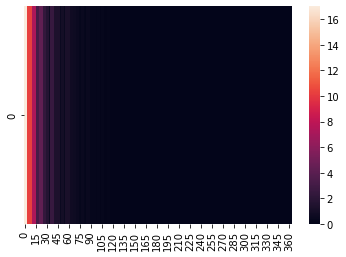

In [235]:
# HEAT MAP
fig, ax = plt.subplots()
sample = X_train.sample(n=1000)
sn.heatmap([np.square(X_train).mean()], ax=ax)
plt.show()

In [95]:
# Multiclass classification with CNN

class PlotLearning(keras.callbacks.Callback):
    """ Callback to plot the learning curves of the model during training."""
    
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if "val" not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs["val_" + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics["val_" + metric], 
                            label="val_" + metric)
            axs[i].legend()
            axs[i].grid()
        plt.tight_layout()
        plt.show()
    
def act_fn(x):
    return keras.activations.relu(x,alpha=1e-2) # leaky-ReLU activation

def cnn_model(input_shape, lr=1e-3):
    model = Sequential()
    model.add(Conv2D(128, 3, activation=act_fn, input_shape=input_shape))
    # model.add(MaxPooling2D(pool_size=(1,1)), padding="valid")
    model.add(Flatten())
    model.add(Dense(128, activation=act_fn))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    model.compile(optimizer=Adam(learning_rate=lr), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def mlp_model(hp, input_shape, lr=1e-3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(Dense(units=hp.Int(f"units_{i}", min_value=16, max_value=256, step=16), activation=act_fn))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# CV
def cross_validate(X, y, n_splits=5, batch_size=64, epochs=100, lr=1e-3):
    histories = []
    callbacks_list = [PlotLearning()]
    for train_idx, test_idx in StratifiedKFold(n_splits=n_splits, shuffle=True).split(X,y):
        X_train, y_train = np.stack(X[train_idx]), y[train_idx]
        X_test, y_test = np.stack(X[test_idx]), y[test_idx]
        X_train, X_test = X_train.reshape(X_train.shape + (1,)), X_test.reshape(X_test.shape + (1,))
        y_train, y_test = keras.utils.to_categorical(y_train), keras.utils.to_categorical(y_test)
        input_shape = X_train.shape[1:]
        model = cnn_model(input_shape, lr=lr)
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks_list).history
        histories.append(history)
    print(model.summary())
    return model, histories

# Train
def tune_model(tuner, data, batch_size=64, epochs=100, lr=1e-3, **kwargs):
    callbacks_list = [EarlyStopping(monitor="val_loss", patience=20, verbose=1)]
    X_train, X_val, y_train, y_val = data
    X_train, X_val = np.stack(X_train), np.stack(X_val)
    y_train, y_val = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES), keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)
    tuner.search(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=batch_size, epochs=epochs,
                     verbose=1, shuffle=True, callbacks=callbacks_list)

def train_model(model, data, batch_size=64, epochs=100, lr=1e-3, **kwargs):
    histories = []
    callbacks_list = [PlotLearning(), EarlyStopping(monitor="val_loss", patience=30, verbose=1)]
    X_train, X_val, y_train, y_val = data
    X_train, X_val = np.stack(X_train), np.stack(X_val)
    y_train, y_val = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES), keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)
    print(model.summary())
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=batch_size, epochs=epochs,
                     verbose=1, shuffle=True, callbacks=callbacks_list)
    histories.append(hist.history)
    return model, histories

# Plot
def plot_histories(histories, metrics=[]):
    """
    function to plot the histories of data
    """
    fig, axes = plt.subplots(nrows = (len(metrics) - 1) // 2 + 1, ncols=2, figsize=(12, 12))
    axes = axes.reshape((len(metrics) - 1) // 2 + 1, 2)
    for i, metric in enumerate(metrics):
        for history in histories:
            ax = axes[(i+2)//2 - 1, 1 - (i+1)%2]
            ax.plot(history[metric])
            ax.legend([i for i in range(len(histories))])
            ax.set_xticks(np.arange(max(history[metric])))
            ax.set_xticklabels(np.arange(max(history[metric])))
            
def plot_simple(histories, metrics=["accuracy", "val_accuracy"]):
    fig, ax = plt.subplots()
    for metric in metrics:
        avg = np.mean(np.array([history[metric] for history in histories]), axis=0)
        ax.plot(avg)

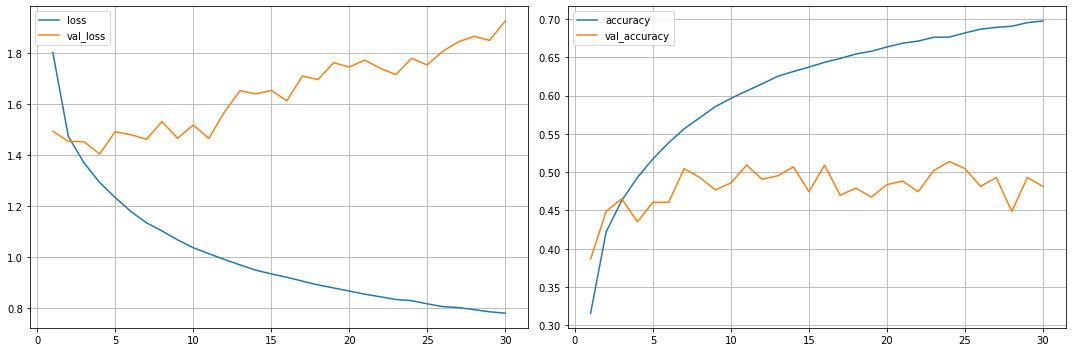

2916/2916 [==============================] - 6s 2ms/step - loss: 0.7797 - accuracy: 0.6974 - val_loss: 1.9245 - val_accuracy: 0.4815
Epoch 31/200
 637/2916 [=====>........................] - ETA: 4s - loss: 0.7492 - accuracy: 0.7119

KeyboardInterrupt: 

In [114]:
batch_size, epochs, lr = 32, 200, 1e-3
train, val = pluecker_train, pluecker_val
X_train, X_val, y_train, y_val = train["pad"], val["pad"], train["pic"], val["pic"]
input_shape = (len(X_train.iloc[0]),)
tuner = RandomSearch(hypermodel=partial(mlp_model, input_shape=input_shape),
                     objective="val_accuracy",
                     max_trials=3,
                     executions_per_trial=2,
                     overwrite=True,
                     directory="../data",
                     project_name="search")
print(tuner.search_space_summary())
model = mlp_model(best_hp, input_shape=input_shape)
data = (X_train, X_val, y_train, y_val)
train_model(model, data, batch_size=batch_size, epochs=epochs, lr=lr);
# res = tune_model(tuner, data, batch_size=batch_size, epochs=epochs, lr=lr)
# tuner.results_summary()
# best_hp = tuner.get_best_hyperparameters(1)[0]

In [546]:
batch_size, epochs, lr = 256, 300, 1e-3
input_shape = (3, 14, 1)
model = cnn_model(input_shape, lr=lr)
model, histories = train_model(model, train_val_100, batch_size=batch_size, epochs=epochs, lr=lr)

KeyboardInterrupt: 